# Imperfect tests and respondent-driven sampling

For now, we consider the network dependence induced by the RDS with no
associated model. Therefore, we treat it as a random effect for
each individual. Conditionally autoregressive (CAR) models in the
Gaussian case are used. Let $[\tilde{Q}]_{ij} = \tilde{q}_{ij}$ be a fixed matrix which measures the distance between $i$
and $j$, and $\tilde{q}_{i+} = \sum_{j} \tilde{q}_{ij}$. In general, we use

$$
\tilde{q}_{ij} = \begin{cases}
  1, &\text{if } i \text{ recruited } j \text{ or the contrary} \\
  0, &\text{otherwise.} 
\end{cases}
$$

Next we define the scaled adjacency matrix $Q = D^{-1}\tilde{Q}$, such that $D$
is a diagonal matrix with $D_{ii} = \tilde{q}_{i+}$. Finally let $|\rho| < 1$ be a
parameter to controls the dependence between neighbors. Hence, we specify the
model as follows:

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta + \omega_i,  \\
    \omega_i|\{\omega_j\}_{j\neq i}, \tau &\sim \operatorname{Normal}\left(\rho\sum_j q_{ij}\omega_j, \tau^{-1}/\tilde{q}_{i+}\right) \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\  
    \tau &\sim \operatorname{Gamma}(a^{\tau}, b^{\tau}).
  \end{aligned}  
\end{equation}

By Brook's Lemma {cite:t}`brook1964distinction`, the joint distribution of
$\omega$ can be specified as 

$$
\omega \sim \operatorname{Normal}\left(0, \left[\tau (D - \rho \tilde{Q})\right]^{-1}\right).
$$

In [1]:
import numpy as np
import pystan as ps
import stan_utility
from scipy.special import logit, expit
from scipy.stats import chi2_contingency
from scipy.stats import beta as betadist
from scipy.stats import gamma as gammadist
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData

## Notebook settings

In [3]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan model 

As usual, we can saved a compiled version for future experiments. 

In [30]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_v5.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'wb') as f:
        pickle.dump(sm, f)
        
sm_imp = pickle.load(open('../models/primary_model/pickles/imperfect_test.pkl', 'rb'))

Below we can see the necessary information to the stan code. 

In [5]:
structure = sm.model_code.split('}')
print(structure[7] + '}') 

 
data {
    int<lower=0> n_samples;
    int<lower=0> n_predictors; 
  
    int<lower=0, upper=1> Y[n_samples];
    matrix[n_samples, n_predictors] X;

    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
    real<lower = 0> alpha_rho; 
    real<lower = 0> beta_rho;

    real<lower = 0> alpha_tau; 
    real<lower = 0> beta_tau;
    real<lower = 0> lambda_tau;
    real<lower = 0> M_sigma;
    int<lower = 0, upper = 2> tau_prior;
    
    matrix<lower = 0, upper = 1>[n_samples, n_samples] adj_matrix; 
    int adj_pairs;
}


The parameters and transformed parameters of the model. 

In [5]:
print(structure[17] + '}' + structure[18] + '}') 


parameters {
    vector[n_predictors] normal_raw; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
    real<lower = 0, upper = 1/max_lambda> rho;
    
    vector[n_samples] omega; 
    real<lower = lower_bound_tau> tau; 
}
transformed parameters {
    vector<lower = 0, upper = 1>[n_samples] p;
    vector[n_predictors] effects; 
    effects = mu + sigma * normal_raw; 
    p = (1 - spec) + (spec + sens - 1) * inv_logit(logit(prev) + X * effects + (1/sqrt(tau)) * omega);
}


The model

In [6]:
print(structure[19] + '}' + structure[20] + '}' + structure[21] + '}' + structure[22] + '}') 


model {
    if (tau_prior == 0){
        tau ~ gamma(alpha_tau, beta_tau); 
    } else if (tau_prior == 1) {
       tau ~ gumbel_type2(lambda_tau);
    } else {
       tau ~ gamma_a(M_sigma);
    }
    
    rho ~ beta(alpha_rho, beta_rho);
    omega ~ sparse_car(rho, adj_sparse, D_sparse, lambda, n_samples, adj_pairs);

    normal_raw ~ std_normal();
    prev ~ beta(alpha_p, beta_p);
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);

    Y ~ bernoulli(p);
}


## Simulated data

First we describe data created artificially as it was generated by this model.
It serves as a confirmation of functionality of the code. First we get the
data using the class `GenerateData()`. 

Note that we actually only need the adjacency matrix. In the following, we
will use to aggregate that to the entire data. 

In [6]:
def simulation(n_samples, rule, parameters_rule, rho, tau, RDS_R=0,
               prevalence=0.1, gamma_s=0.9, gamma_e=0.8, beta=np.array([-0.1, 2.5, 1.4, -1.8, 0.3]),
               n_pred_cont=3, n_pred_binary=2, seed=63289371):
    
    ro = np.random.RandomState(seed)
    
    gen_graph = GenerateData()
    graph = gen_graph.random_graph(rule=rule, 
                                   parameters=parameters_rule)
    rds_sample = gen_graph.RDS_generator(graph = graph, seed = 2000, 
                                         n_seeds=10, sample_size = n_samples, 
                                         probs = [1/3,1/6,1/6,1/3], R=RDS_R)
        
    rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))
    A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray()
    n_samples = rds_sample.number_of_nodes()
    D = np.diag(A.sum(axis = 1))
    
    n_predictors = n_pred_cont + n_pred_binary
    x = np.zeros((n_samples, n_predictors))
    x[:, :n_pred_cont] = ro.multivariate_normal(mean = np.zeros(n_pred_cont), 
                                                cov = np.eye(n_pred_cont),
                                                size = n_samples)
    x[:, :n_pred_cont] = 0.5 * (x[:, :n_pred_cont] - x[:, :n_pred_cont].mean(axis=0))/x[:, :n_pred_cont].std(axis = 0)
    x[:, n_pred_cont:] = ro.binomial(n = 1, p = [0.3, 0.7], size = (n_samples, n_pred_binary))
    if rule[-12:] == 'preferential':
        x[:, -1] = np.array([k[1]['binary'] for k in list(rds_sample.nodes.data())])
    
    omega = ro.multivariate_normal(mean = np.zeros(n_samples), 
                                   cov = (1/tau)*np.linalg.inv(D - rho*A), 
                                   ).reshape(-1,1)
    x_effects = (x@beta).reshape(n_samples, 1)
    theta = expit(logit(prevalence) + x_effects + omega)
    p = 1-gamma_e + (gamma_e+gamma_s-1)*theta
    T = ro.binomial(n=1, p=p)
                          
    data = {
        "n_samples"    : n_samples,
        "n_predictors" : n_predictors,
        "Y"            : T.flatten(),
        "X"            : x,
        "adj_matrix"   : A, 
        "adj_pairs"    : int(A.sum()//2)
    } 
    
    return data, theta, p, omega, rds_sample

In [10]:
data, _, _, omega1, rds_sample = simulation(n_samples=400, 
                                           rule='erdos-renyi', 
                                           parameters_rule={'n': 10000, 'p': 0.005, 'seed': 63217985},
                                           seed=63217985,
                                           rho=0.9995,
                                           tau=1,
                                           RDS_R=0)

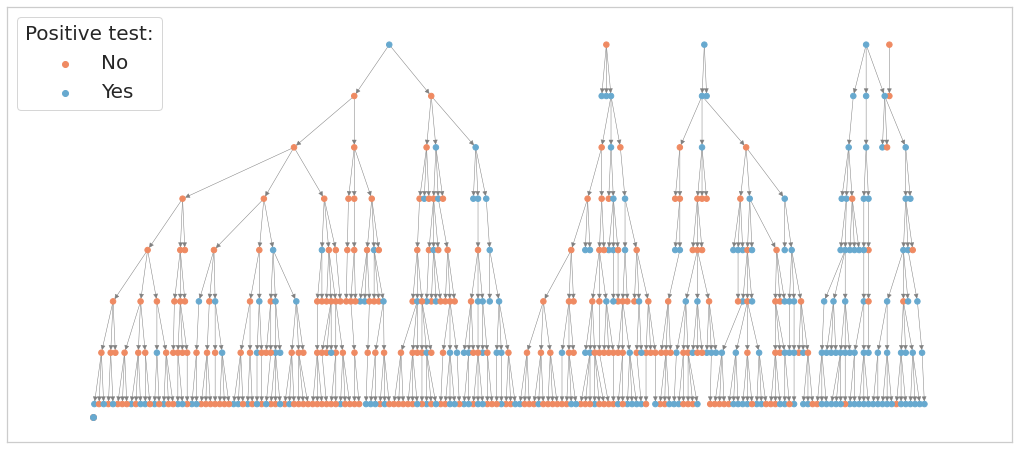

In [9]:
color_map = {0: "#ef8a62", 1: "#67a9cf"}
colors = [color_map[data['Y'][n]] for n in range(data['n_samples'])]

options = {
    'node_color': colors,
    'node_size': 30,
    'with_labels': False,
    'font_weight': 'bold',
    'edge_color': 'grey',
    'width': 0.5
}

sns.set(style='whitegrid')
plt.figure(figsize = (18,8))
pos = graphviz_layout(rds_sample, prog="dot")

for label in [0,1]:
    plt.scatter([0],[0], color=color_map[label], label={0:'No', 1:'Yes'}[label])

nx.draw_networkx(rds_sample, pos, **options)

plt.grid(False)
legend = plt.legend(loc="upper left", title = "Positive test:", prop = {'size': 20})
plt.setp(legend.get_title(),fontsize=20)
plt.savefig('../images/rds_erdos_renyi_experiment1.pdf', bbox_inches = 'tight')
plt.show()

sns.set()

In [165]:
G = nx.convert_node_labels_to_integers(rds_sample, label_attribute="name")
counter = np.zeros((2,2))
for node in G.nodes():
    for j in G.successors(node):
        counter[data['Y'][node], data['Y'][j]] += 1
chi2_contingency(counter)

(25.723052181738076,
 3.940914684678266e-07,
 1,
 array([[160.18480493, 129.81519507],
        [108.81519507,  88.18480493]]))

In [19]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(5),
    "mu"           : [0, 2, 1.5, -2, 0],
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 0, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

In [27]:
data['p'] = 5
data['T'] = data['Y']
data['alpha_prev'] = data['alpha_p']
data['beta_prev'] = data['beta_p']
data['M_tau'] = data['M_sigma']
data['mu_beta'] = data['mu']
data['cov_beta'] = data['Sigma']

In [29]:
%%time
fit_imperfect_rds = sm.sampling(data=data, warmup=2000, 
                                iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 998 ms, sys: 123 ms, total: 1.12 s
Wall time: 9min 44s


In [149]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.110,0.138,0.000,0.379,0.007,0.005,489.0,744.0,1.01
sens,0.904,0.055,0.804,0.995,0.001,0.001,5705.0,5939.0,1.00
spec,0.816,0.026,0.769,0.866,0.000,0.000,2816.0,4101.0,1.00
effects[0],-0.350,0.618,-1.475,0.845,0.007,0.006,7289.0,5970.0,1.00
effects[1],3.065,0.734,1.777,4.545,0.011,0.008,4568.0,5469.0,1.00
effects[2],1.140,0.642,-0.065,2.345,0.008,0.006,7034.0,5796.0,1.00
effects[3],-1.487,0.707,-2.808,-0.209,0.008,0.006,8956.0,7103.0,1.00
effects[4],0.838,0.625,-0.322,2.021,0.009,0.006,4980.0,5312.0,1.00
tau,1.086,0.854,0.120,2.592,0.031,0.022,750.0,2033.0,1.00
rho,0.998,0.004,0.993,1.000,0.000,0.000,285.0,734.0,1.02


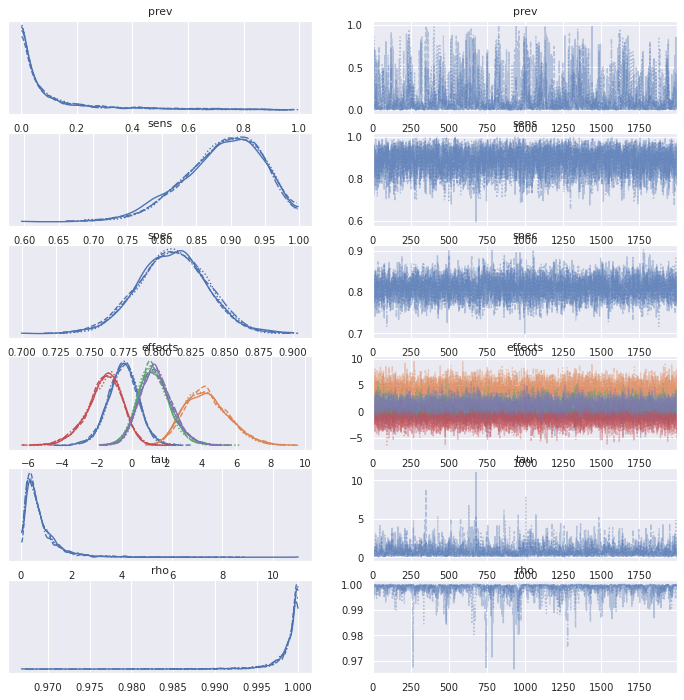

In [129]:
az.plot_trace(fit_imperfect_rds)
plt.show()

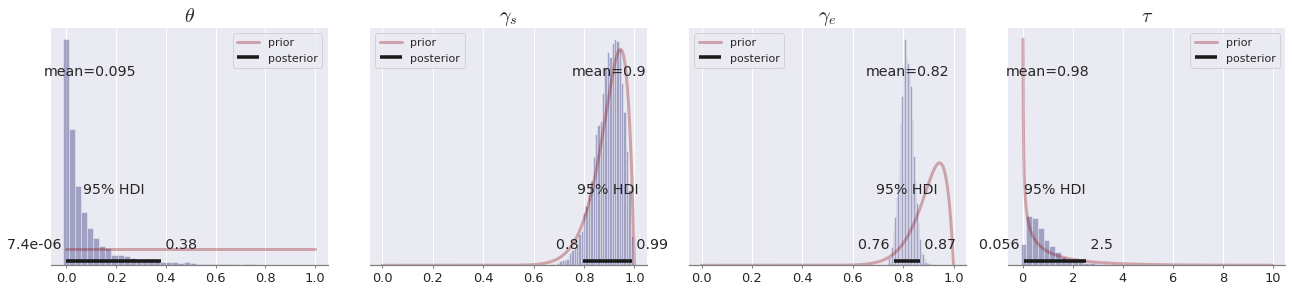

In [45]:
fig, ax = plt.subplots(1,4,figsize = (18,4))

t = np.linspace(0,1,1000)
x = np.linspace(0,10,1000)
ax[0].plot(t, betadist(1,1).pdf(t), color='darkred', alpha=0.3, linewidth=3, label='prior')
ax[1].plot(t, betadist(18,2).pdf(t), color='darkred', alpha=0.3, linewidth=3, label='prior')
ax[2].plot(t, betadist(18,2).pdf(t), color='darkred', alpha=0.3, linewidth=3, label='prior')
ax[3].plot(x, gammadist(a=0.5, scale=2).pdf(x), color='darkred', alpha=0.3, linewidth=3, label='prior')

az.plot_posterior(fit_imperfect_rds, var_names=['prev', 'sens', 'spec', 'tau'], 
                  ax = ax, kind='hist', density=True, bins=40, grid = (1, 4),
                  hdi_prob = 0.95, color = 'midnightblue', textsize = 13)

ax[0].set_title(r'$\theta$', fontsize = 20)
ax[1].set_title(r'$\gamma_s$', fontsize = 20)
ax[2].set_title(r'$\gamma_e$', fontsize = 20)
ax[3].set_title(r'$\tau$', fontsize = 20)

for i in range(4): ax[i].legend(('prior', 'posterior'))
    
# for k, real in enumerate((0.1, 0.9, 0.8, 1, 0.995)): 
#     i = k // 3
#     j = k % 3
#     ax[i,j].axvline(real, color='darkolivegreen', label='True value')
#     ax[i,j].legend()

fig.tight_layout(pad = 0.5)
plt.savefig('../images/posterior_rds_imperfect_tests_exp1.pdf', bbox_inches = 'tight')
plt.show()

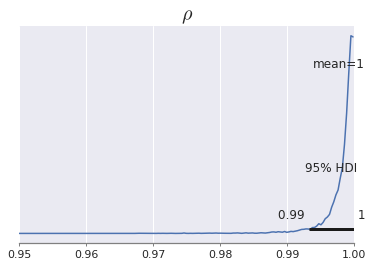

In [59]:
ax = az.plot_posterior(fit_imperfect_rds, var_names=['rho'], hdi_prob=0.95)
ax.set_xlim((0.95,1))
ax.set_title(r'$\rho$', fontsize=20)
plt.savefig('../images/posterior_rds_imperfect_tests_exp1_rho.pdf', bbox_inches = 'tight')
plt.show()

In [95]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.105,0.146,0.000,0.385,0.006,0.004,682.0,1031.0,1.00
sens,0.900,0.056,0.798,0.992,0.001,0.000,6153.0,5689.0,1.00
spec,0.816,0.026,0.768,0.868,0.000,0.000,3300.0,4984.0,1.00
effects[0],-0.543,0.771,-1.940,0.986,0.009,0.007,7464.0,6546.0,1.00
effects[1],3.445,1.067,1.576,5.467,0.016,0.012,4385.0,5693.0,1.00
effects[2],0.960,0.770,-0.414,2.506,0.009,0.008,7339.0,5851.0,1.00
effects[3],-1.032,0.842,-2.622,0.517,0.009,0.008,8252.0,6495.0,1.00
effects[4],1.239,0.824,-0.201,2.888,0.013,0.010,3879.0,5301.0,1.00
tau,1.014,0.839,0.067,2.516,0.020,0.014,1601.0,3173.0,1.00
rho,0.998,0.003,0.995,1.000,0.000,0.000,558.0,1140.0,1.01


In [150]:
%%time
fit_imperfect = sm_imp.sampling(data=data, warmup=2000, 
                                iter=4000, pars=('prev', 'sens', 'spec', 'effects'))
summary2 = az.summary(fit_imperfect)

CPU times: user 222 ms, sys: 54 ms, total: 276 ms
Wall time: 6.06 s


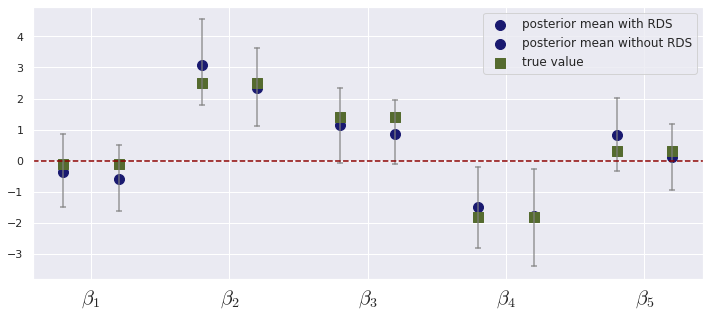

In [151]:
fig, ax = plt.subplots(figsize = (12,5))

for i in range(5): 
    par = "effects[{}]".format(i)
    ax.plot([i-0.2,i-0.2], [summary.loc[par,"hdi_3%"], summary.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8)
    ax.scatter([i-0.2,i-0.2], [summary.loc[par,"hdi_3%"], summary.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8, marker = '_')
    ax.plot([i+0.2,i+0.2], [summary2.loc[par,"hdi_3%"], summary2.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8)
    ax.scatter([i+0.2,i+0.2], [summary2.loc[par,"hdi_3%"], summary2.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8, marker = '_')

ax.scatter([i-0.2 for i in range(5)], summary["mean"].values[3:8], color = 'midnightblue', s = 100, 
           label = r"posterior mean with RDS")
ax.scatter([i+0.2 for i in range(5)], summary2["mean"].values[3:8], color = 'midnightblue', s = 100, 
           label = r"posterior mean without RDS")
ax.scatter([i-0.2 for i in range(5)], [-0.1, 2.5, 1.4, -1.8, 0.3], color = 'darkolivegreen', s = 100, marker = 's', label = r"true value")
ax.scatter([i+0.2 for i in range(5)], [-0.1, 2.5, 1.4, -1.8, 0.3], color = 'darkolivegreen', s = 100, marker = 's')
ax.axhline(0, linestyle='--', color='darkred')

ax.legend(fontsize = 12)

ax.set_xticks(range(5))
ax.set_xticklabels(labels=[r"$\beta_{}$".format(i) for i in range(1,6)], fontsize = 20)

#plt.savefig("../images/credible_intervals_effects_comparison_rds.pdf", bbox_inches = "tight")
plt.show()

## Stronger priors 

In [82]:
# Hyperparameters of the model. 
data.update({    
    "alpha_p"      : 3,
    "beta_p"       : 20,
    "alpha_rho"    : 9,
    "beta_rho"     : 1
})

In [83]:
%%time
fit_imperfect_rds = sm.sampling(data=data, warmup=2000, 
                                iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

CPU times: user 365 ms, sys: 47.9 ms, total: 413 ms
Wall time: 7min 10s


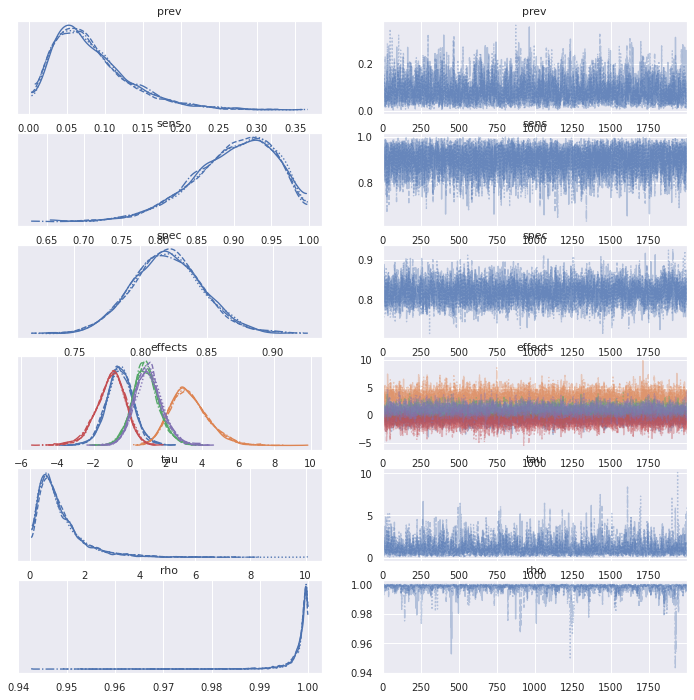

In [84]:
az.plot_trace(fit_imperfect_rds)
plt.show()

In [85]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.083,0.050,0.009,0.177,0.001,0.001,1967.0,4095.0,1.00
sens,0.899,0.055,0.801,0.991,0.001,0.000,6441.0,5864.0,1.00
spec,0.820,0.027,0.771,0.871,0.001,0.000,2158.0,3154.0,1.00
effects[0],-0.543,0.740,-2.003,0.807,0.008,0.006,7976.0,6978.0,1.00
effects[1],3.278,1.049,1.544,5.424,0.022,0.015,2266.0,4860.0,1.00
effects[2],0.887,0.742,-0.462,2.383,0.009,0.008,6754.0,5498.0,1.00
effects[3],-1.046,0.827,-2.587,0.464,0.010,0.008,7230.0,5461.0,1.00
effects[4],1.042,0.768,-0.380,2.515,0.017,0.012,2006.0,3363.0,1.00
tau,1.083,0.836,0.094,2.578,0.020,0.014,1771.0,3405.0,1.00
rho,0.998,0.003,0.994,1.000,0.000,0.000,550.0,799.0,1.01


## Experiment 2 

$\tau = 10000$

In [279]:
data, _, _, omega2, rds_sample = simulation(n_samples=400, 
                                           rule='erdos-renyi', 
                                           parameters_rule={'n': 10000, 'p': 0.005, 'seed': 63217985},
                                           seed=63217985,
                                           rho=0.9995,
                                           tau=10000,
                                           RDS_R=0)

data, theta, p, omega3, rds_sample = simulation(n_samples=400, 
                                           rule='erdos-renyi', 
                                           parameters_rule={'n': 10000, 'p': 0.005, 'seed': 63217985},
                                           seed=63217985,
                                           rho=0.99999,
                                           tau=10,
                                           RDS_R=0)

In [284]:
G = nx.convert_node_labels_to_integers(rds_sample, label_attribute="name")
counter = np.zeros((2,2))
for node in G.nodes():
    for j in G.successors(node):
        counter[data['Y'][node], data['Y'][j]] += 1
chi2_contingency(counter)

(19.612690968130536,
 9.483716003721325e-06,
 1,
 array([[211.55030801, 113.44969199],
        [105.44969199,  56.55030801]]))

In [285]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : 4 * np.eye(5),
    "mu"           : [0, 0, 0, 0, 0],
    "alpha_p"      : 3,
    "beta_p"       : 20,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.1, 
    "beta_tau"     : 0.1, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 900,
    "beta_rho"     : 1
})

In [288]:
%%time
fit_imperfect_rds = sm.sampling(data=data, iter=4000, pars=('prev', 'tau', 'rho'),
                                control={'max_treedepth': 12})
summary = az.summary(fit_imperfect_rds)

CPU times: user 288 ms, sys: 98.9 ms, total: 387 ms
Wall time: 16min 50s


In [301]:
def gumbel_dist(tau, rate): 
    return rate/2 * np.exp(-1.5 * np.log(tau) - rate / np.sqrt(tau)) 

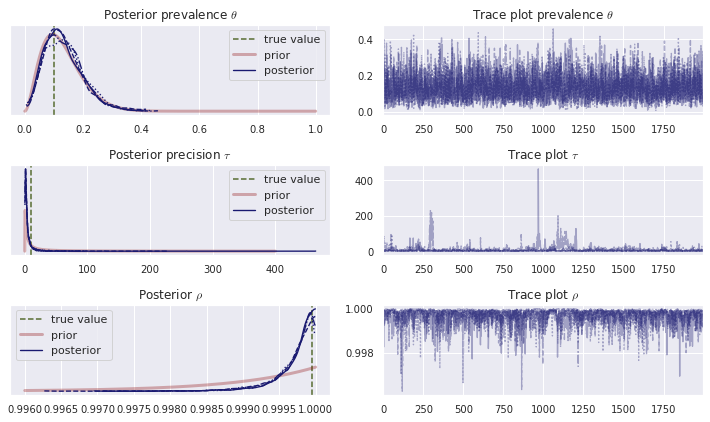

In [311]:
fig, ax = plt.subplots(3, 2, figsize = (10,6))

ax[0,0].axvline(0.1, color='darkolivegreen', linestyle='--')
ax[1,0].axvline(10, color='darkolivegreen', linestyle='--')
ax[2,0].axvline(0.99995, color='darkolivegreen', linestyle='--')

t = np.linspace(0,1,1000)
ax[0,0].plot(t, betadist(3,20).pdf(t), color='darkred', alpha=0.3, linewidth=3)
t = np.linspace(0.001,400,1000)
ax[1,0].plot(t, gumbel_dist(t, np.log(10)), color='darkred', alpha=0.3, linewidth=3)
t = np.linspace(0.996,1,1000)
ax[2,0].plot(t, betadist(900,1).pdf(t), color='darkred', alpha=0.3, linewidth=3)

az.plot_trace(fit_imperfect_rds, 
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', ':', '-.']}, 
              axes=ax)

for i in range(3): ax[i,0].legend(('true value', 'prior', 'posterior'))

ax[0,0].set_title(r'Posterior prevalence $\theta$')
ax[0,1].set_title(r'Trace plot prevalence $\theta$')
ax[1,0].set_title(r'Posterior precision $\tau$')
ax[1,1].set_title(r'Trace plot $\tau$')
ax[2,0].set_title(r'Posterior $\rho$')
ax[2,1].set_title(r'Trace plot $\rho$')

fig.tight_layout(pad=1.0)
plt.savefig('../images/trace_plot_experiment2_gumbel_imperfect_test_rds.pdf', bbox_inches = 'tight')
plt.show()

In [291]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.135,0.066,0.025,0.252,0.002,0.001,1749.0,3292.0,1.0
tau,5.674,12.610,0.134,16.896,0.662,0.468,426.0,353.0,1.0
rho,1.000,0.000,0.999,1.000,0.000,0.000,397.0,375.0,1.0


In [242]:
%%time
fit_imperfect = sm_imp.sampling(data=data, iter=4000, pars=('prev', 'sens', 'spec', 'effects'))
summary2 = az.summary(fit_imperfect)

CPU times: user 301 ms, sys: 68.3 ms, total: 369 ms
Wall time: 7.31 s


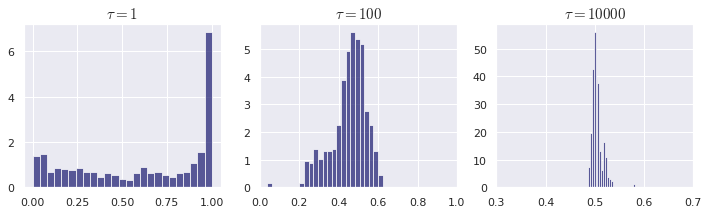

In [210]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].hist(expit(omega1), bins=25, alpha=0.7, density=True, color='midnightblue')
ax[1].hist(expit(omega3), bins=25, alpha=0.7, density=True, color='midnightblue')
ax[2].hist(expit(omega2), bins=25, alpha=0.7, density=True, color='midnightblue')
ax[0].set_title(r'$\tau = 1$', fontsize=15)
ax[1].set_title(r'$\tau = 100$', fontsize=15)
ax[2].set_title(r'$\tau = 10000$', fontsize=15)
ax[1].set_xlim((0,1))
ax[2].set_xlim((0.3,0.7))
plt.savefig('../images/tau-influence-probability-space.pdf', bbox_inches='tight')
plt.show()

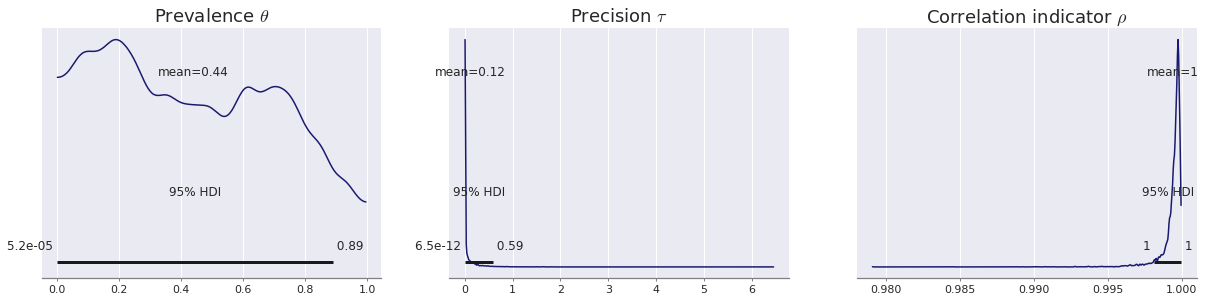

In [243]:
ax = az.plot_posterior(fit_imperfect_rds, var_names=['prev', 'tau', 'rho'], color='midnightblue', hdi_prob=0.95)
ax[0].set_title(r'Prevalence $\theta$', fontsize=18)
ax[1].set_title(r'Precision $\tau$', fontsize=18)
ax[2].set_title(r'Correlation indicator $\rho$', fontsize=18)
#plt.savefig('../images/posterior_parameters_rds_tau100.pdf', bbox_inches='tight')
plt.show()

## Experiment 4

In [31]:
data, _, _, _, rds_sample = simulation(n_samples=300, 
                                       rule='erdos-renyi-preferential', 
                                       parameters_rule={'n': 10000, 'p1': 0.008, 'p2': 0.004, 'p_z1': 0.3, 'seed': 397381297},
                                       seed=397381297,
                                       rho=0.9999,
                                       tau=10,
                                       RDS_R=0.5)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
data2, _, _, _, rds_sample = simulation(n_samples=300, 
                                       rule='barabasi-albert', 
                                       parameters_rule={'n': 10000, 'm': 25, 'seed': 397381297},
                                       seed=397381297,
                                       rho=0.9999,
                                       tau=5,
                                       RDS_R=0)

In [33]:
data3, _, _, _, rds_sample = simulation(n_samples=300, 
                                        rule='barabasi-albert-preferential', 
                                        parameters_rule={'n': 10000, 'm': 25, 'p': 0.5, 'p_z1': 0.3, 'seed': 397381297},
                                        seed=397381297,
                                        rho=0.99999,
                                        tau=5,
                                        RDS_R=0.5)

  0%|          | 0/9975 [00:00<?, ?it/s]

In [34]:
# Hyperparameters of the model. 

hyperparameters = {    
    "Sigma"        : 4 * np.eye(5),
    "mu"           : [0, 0, 0, 0, 0],
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 0, 
    "alpha_tau"    : 0.1, 
    "beta_tau"     : 0.1, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
}

data.update(hyperparameters)
data2.update(hyperparameters)
data3.update(hyperparameters)

In [35]:
%%time
fit_imperfect_rds = sm.sampling(data=data, warmup=2500, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'))
summary = az.summary(fit_imperfect_rds)

with open("../models/model_fit.pkl", "wb") as f:
    pickle.dump({'model' : fit_imperfect_rds}, f, protocol=-1)

CPU times: user 304 ms, sys: 60.3 ms, total: 365 ms
Wall time: 43.4 s


<timed exec>:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


In [36]:
%%time
fit_imperfect_rds2 = sm.sampling(data=data2, warmup=2500, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'))
summary2 = az.summary(fit_imperfect_rds2)

with open("../models/model_fit2.pkl", "wb") as f:
    pickle.dump({'model' : fit_imperfect_rds2}, f, protocol=-1)

<timed exec>:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


CPU times: user 245 ms, sys: 96.5 ms, total: 342 ms
Wall time: 31.8 s


In [37]:
%%time
fit_imperfect_rds3 = sm.sampling(data=data3, warmup=2500, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'))
summary3 = az.summary(fit_imperfect_rds3)

with open("../models/model_fit3.pkl", "wb") as f:
    pickle.dump({'model' : fit_imperfect_rds3}, f, protocol=-1)

CPU times: user 331 ms, sys: 98 ms, total: 429 ms
Wall time: 6min 43s


<timed exec>:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


In [44]:
# Hyperparameters of the model. 

hyperparameters = {    
    "Sigma"        : np.eye(5),
    "mu"           : [0, 2.5, 1.4, -2, 0],
    "alpha_p"      : 3,
    "beta_p"       : 20,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 0, 
    "alpha_tau"    : 0.1, 
    "beta_tau"     : 0.1, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 900,
    "beta_rho"     : 1
}

data.update(hyperparameters)
data2.update(hyperparameters)
data3.update(hyperparameters)

In [ ]:
%%time
fit_imperfect_rds = sm.sampling(data=data, warmup=2500, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                control={'max_treedepth': 11})
summary = az.summary(fit_imperfect_rds)

with open("../models/model_fit_strong.pkl", "wb") as f:
    pickle.dump({'model' : fit_imperfect_rds}, f, protocol=-1)

In [ ]:
%%time
fit_imperfect_rds2 = sm.sampling(data=data2, warmup=2500, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'), 
                                 control={'max_treedepth': 11, 'adapt_delta': 0.85})
summary2 = az.summary(fit_imperfect_rds2)

with open("../models/model_fit_strong2.pkl", "wb") as f:
    pickle.dump({'model' : fit_imperfect_rds2}, f, protocol=-1)

In [47]:
%%time
fit_imperfect_rds3 = sm.sampling(data=data3, warmup=2500, iter=4000, pars=('prev', 'sens', 'spec', 'effects', 'tau', 'rho'),
                                 control={'max_treedepth': 11, 'adapt_delta': 0.85})
summary3 = az.summary(fit_imperfect_rds3)

with open("../models/model_fit_strong3.pkl", "wb") as f:
    pickle.dump({'model' : fit_imperfect_rds3}, f, protocol=-1)

CPU times: user 460 ms, sys: 117 ms, total: 577 ms
Wall time: 18min 39s


<timed exec>:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
